In [9]:
import importlib

import numpy as np

from utils import data_utils as du
from utils import plot_utils as pu
from utils import stats_utils as su

# Data Loading

In [11]:
importlib.reload(du)
importlib.reload(su)

POLICY_YEAR: int = 2019
START_YEAR: int = 2016
END_YEAR: int = 2023

energy_data = du.load_data()
concurrent_df = du.concurrent_buildings(
    input_df=energy_data, start_year=2016, end_year=2023
)
did_df = su.prepare_did_data(concurrent_df)

did_df["Post"] = (did_df["Data Year"] >= POLICY_YEAR).astype(int)
median_rating = did_df["Chicago Energy Rating"].median(skipna=True)
did_df["LowRating"] = (did_df["Chicago Energy Rating"] <= median_rating).astype(int)
median_score = did_df["ENERGY STAR Score"].median(skipna=True)
did_df["LowScore"] = (did_df["ENERGY STAR Score"] <= median_score).astype(int)

# Statistical Analysis & Modeling

### Pre/post comparisons (2016–2018 vs. 2019–2024) of energy efficiency and emissions.

In [ ]:
energy_df = concurrent_df.copy()
energy_df["Post_Placard"] = (energy_df["Data Year"] >= POLICY_YEAR).astype(int)
energy_df = energy_df[
    (energy_df["Data Year"] >= START_YEAR) & (energy_df["Data Year"] <= END_YEAR)
]

metrics = [
    "Total GHG Emissions (Metric Tons CO2e)",
    "Site EUI (kBtu/sq ft)",
]

summary = (
    energy_df.groupby("Post_Placard")[metrics]
    .agg(["mean", "median"])
    .T.rename_axis(index=["Metric", "Statistic"])
)

summary.columns = ["Pre (2016–2018)", "Post (2019–2023)"]
summary = summary.reset_index()

summary["Percent Change (%)"] = (
    (summary["Post (2019–2023)"] - summary["Pre (2016–2018)"])
    / summary["Pre (2016–2018)"].replace(0, np.nan)
    * 100
).round(2)

summary

,Metric,Statistic,Pre (2016–2018),Post (2019–2023),Percent Change (%)
0,Total GHG Emissions (Metric Tons CO2e),mean,2530.813227,2057.989326,-18.68
1,Total GHG Emissions (Metric Tons CO2e),median,1102.600000,957.950000,-13.12
2,Site EUI (kBtu/sq ft),mean,91.607152,87.177966,-4.83
3,Site EUI (kBtu/sq ft),median,81.700000,77.900000,-4.65


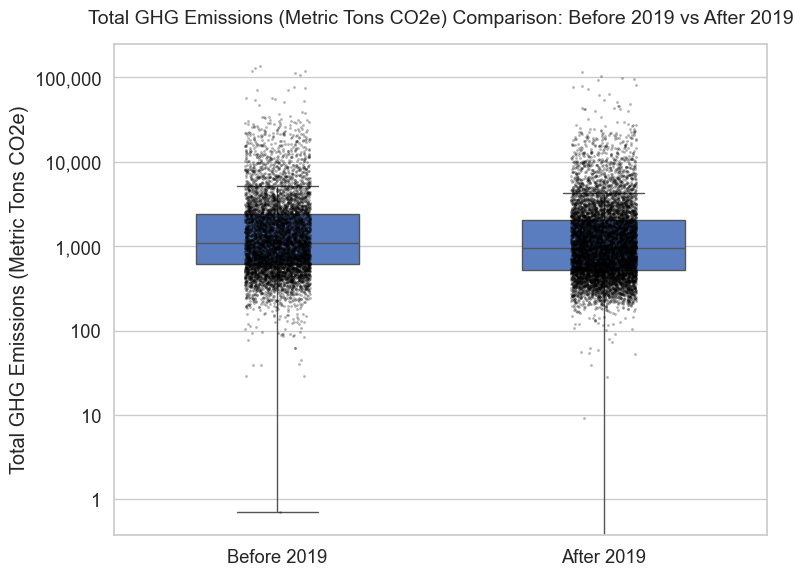

In [ ]:
df_pre = did_df[did_df["Data Year"] < POLICY_YEAR]
df_post = did_df[did_df["Data Year"] >= POLICY_YEAR]
pu.compare_variable_distribution(
    df1=df_pre,
    df2=df_post,
    variable="Total GHG Emissions (Metric Tons CO2e)",
    label1="Before 2019",
    label2="After 2019",
    log_scale=True,
)

### DiD

##### Before/After 2019 + Chicago Energy Rating

$$
{GHG}_{it} =
\alpha
+ \beta_1 \text{Post}_{t}
+ \beta_2 \text{LowRating}_{i}
+ \beta_3 (\text{Post}_{t} \times \text{LowRating}_{i})
+ \gamma_1 \ln(\text{FloorArea}_{i})
+ \gamma_2 \text{PropertyType}_{i}
+ \gamma_3 \text{Year}_{t}
+ \gamma_4 \text{YearBuilt}_{t}
+ \varepsilon_{it}
$$

where  

- $ \text{GHG}_{it} $ : total greenhouse-gas emissions (metric tons CO₂e) for building *i* in year *t*  
- $ \text{Post}_{t}=1 $ : if $t \ge 2019$ (post-placard period), 0 otherwise  
- $ \text{LowRating}_{i}=1 $ : if the building’s initial Chicago Energy Rating ≤ 2 (treated group), 0 otherwise  
- $ \text{Post}_{t}\times\text{LowRating}_{i} $ : interaction capturing the differential change for treated buildings after the policy  
- $ \ln(\text{FloorArea}_{i}) $, $ \text{PropertyType}_{i} $, $ \text{Year}_{t} $ : control variables for building size, type, and year fixed effects  
- $ \varepsilon_{it} $ : error term  


In [323]:
model1 = su.run_did_regression(
    did_df, "Total GHG Emissions (Metric Tons CO2e)", include_data_year=True
)
su.summarize_did_results(model1)

,coef,std_err,p_value,Significance
Intercept,-35191.6005,1508.2286,0.0000,***
Post,-1030.1609,93.6346,0.0000,***
LowRating,721.4442,176.2478,0.0000,***
Post:LowRating,119.7152,183.1954,0.5134,
np.log(Q('Gross Floor Area - Buildings (sq ft)')),3438.6373,124.6547,0.0000,***
Q('Year Built'),-1.6559,0.6627,0.0125,*


In this GHG DID model, the Post-2019 dummy ($\beta_1$), Low-Rating indicator ($\beta_2$), and log floor area are statistically significant.

- After 2019, average GHG emissions per building declined by roughly 1030 metric tons
- Buildings with initially low Chicago Energy Ratings (≤ 2) emitted about 1,121 metric tons more CO2 than originally higher ones
- Interaction term's insignificance indicates that although emissions fell after 2019, low-rated buildings did not experience a significantly different change compared to high-rated ones

$\beta_3$ is relatively small and not significant, impling less effect of placards

In [324]:
model1_log = su.run_did_regression(
    did_df, "Total GHG Emissions (Metric Tons CO2e)", log=True, include_data_year=True
)

su.summarize_did_results(model1_log)

Dropping 1 rows with nonpositive GHG values.


,coef,std_err,p_value,Significance
Intercept,-8.3298,0.1858,0.0000,***
Post,-0.3854,0.0101,0.0000,***
LowRating,0.4469,0.0189,0.0000,***
Post:LowRating,-0.0386,0.0207,0.0621,
np.log(Q('Gross Floor Area - Buildings (sq ft)')),1.0082,0.0042,0.0000,***
Q('Year Built'),0.0018,0.0001,0.0000,***



$$
\text{GHG}_{it} =
\alpha
+ \beta_1 \text{Post}_{t}
+ \beta_2 \text{LowRating}_{i}
+ \beta_3 (\text{Post}_{t} \times \text{LowRating}_{i})
+ \gamma_1 \ln(\text{FloorArea}_{i})
+ \gamma_2 \text{PropertyType}_{i}
+ \gamma_3 \text{YearBuilt}_{t}
+ \varepsilon_{it}
$$

In [325]:
model1_noYear = su.run_did_regression(
    did_df, "Total GHG Emissions (Metric Tons CO2e)", include_data_year=False
)
su.summarize_did_results(model1_noYear, show_all=True)

,coef,std_err,p_value,Significance
Intercept,-35410.4300,1507.4821,0.0000,***
Post,-1183.1427,78.6675,0.0000,***
LowRating,222.1581,149.8872,0.1383,
Post:LowRating,633.8503,165.1927,0.0001,***
np.log(Q('Gross Floor Area - Buildings (sq ft)')),3430.6721,124.2647,0.0000,***
Q('Year Built'),-1.5662,0.6610,0.0178,*


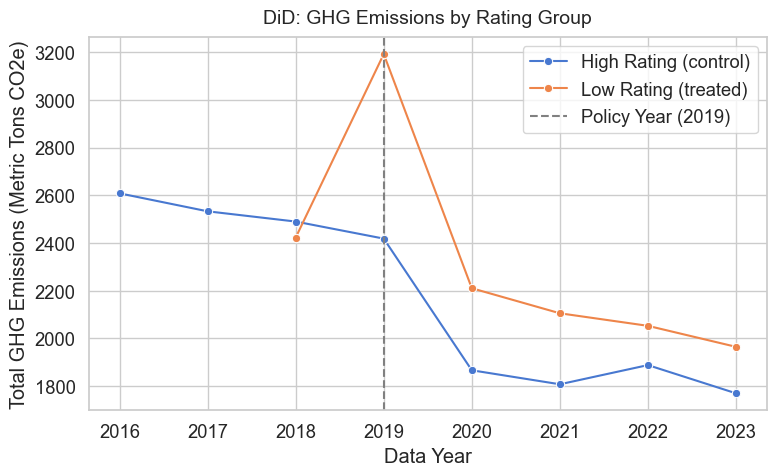

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'DiD: GHG Emissions by Rating Group'}, xlabel='Data Year', ylabel='Total GHG Emissions (Metric Tons CO2e)'>)

In [326]:
pu.plot_did_trend(
    did_df,
    year_col="Data Year",
    group_col="LowRating",
    outcome_col="Total GHG Emissions (Metric Tons CO2e)",
    policy_year=2019,
    group_labels={1: "Low Rating (treated)", 0: "High Rating (control)"},
    title="DiD: GHG Emissions by Rating Group",
)

In [ ]:
rating_counts = concurrent_df["Chicago Energy Rating"].value_counts().sort_index()
print("\nOverall distribution of ratings:")
print(rating_counts)

rating_by_year = concurrent_df.pivot_table(
    index="Data Year",
    columns="Chicago Energy Rating",
    values="ID",
    aggfunc="count",
    fill_value=0,
).sort_index()

print("\nDistribution of ratings by year:")
display(rating_by_year)


Overall distribution of ratings:
Chicago Energy Rating
0.0    1782
1.0    1861
1.5     696
2.0    1480
2.5    1097
3.0    1509
3.5    1384
4.0    3776
Name: count, dtype: int64

Distribution of ratings by year:


Chicago Energy Rating,0.0,1.0,1.5,2.0,2.5,3.0,3.5,4.0
Data Year,,,,,,,,
2018,80,414,172,311,182,282,195,676
2019,592,263,127,249,172,212,175,453
2020,167,237,69,249,179,253,269,877
2021,332,297,100,194,175,253,247,641
2022,358,310,108,243,191,249,235,549
2023,253,340,120,234,198,260,263,580


##### Before/After 2019 + Energy STAR Score

$$
\text{GHG}_{it}
= \alpha
+ \beta_1 \text{Post}_t
+ \beta_2 \text{LowScore}_i
+ \beta_3 (\text{Post}_t \times \text{LowScore}_i)
+ \gamma_1 \ln(\text{FloorArea}_i)
+ \gamma_2 \text{PropertyType}_i
+ \gamma_3 \text{YearBuilt}_i
+ \varepsilon_{it}
$$


In [260]:
if "LowScore" not in did_df.columns:
    median_score = did_df["ENERGY STAR Score"].median(skipna=True)
    print(f"Median ENERGY STAR Score: {median_score:.1f}")
    did_df["LowScore"] = (did_df["ENERGY STAR Score"] <= median_score).astype(int)

model2 = su.run_did_regression(
    did_df,
    "Total GHG Emissions (Metric Tons CO2e)",
    log=False,
    include_data_year=True,
    treatment_col="LowScore",
)

su.summarize_did_results(model2)

,coef,std_err,p_value,Significance
Intercept,-35290.8664,1511.3160,0.0000,***
Post,-723.4695,101.0834,0.0000,***
LowScore,253.7037,108.1923,0.0190,*
Post:LowScore,203.9611,133.8089,0.1274,
np.log(Q('Gross Floor Area - Buildings (sq ft)')),3422.1305,123.6932,0.0000,***
Q('Year Built'),-1.5582,0.6539,0.0172,*


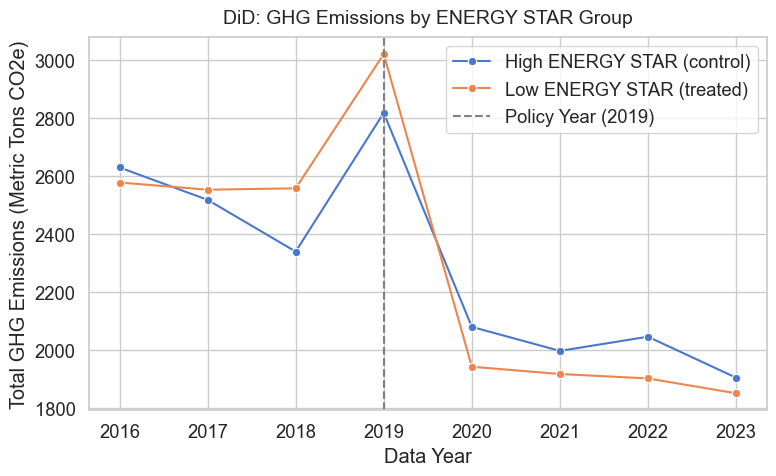

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'DiD: GHG Emissions by ENERGY STAR Group'}, xlabel='Data Year', ylabel='Total GHG Emissions (Metric Tons CO2e)'>)

In [330]:
pu.plot_did_trend(
    did_df,
    year_col="Data Year",
    group_col="LowScore",
    outcome_col="Total GHG Emissions (Metric Tons CO2e)",
    policy_year=2019,
    group_labels={1: "Low ENERGY STAR (treated)", 0: "High ENERGY STAR (control)"},
    title="DiD: GHG Emissions by ENERGY STAR Group",
)

Low-score buildings’ emissions decreased less than high-score buildings after 2019, but the difference is not statistically significant.

##### Site EUI

In [ ]:
model3_score = su.run_did_regression(
    did_df,
    "Site EUI (kBtu/sq ft)",
    log=True,
    include_data_year=False,
    treatment_col="LowScore",
)

su.summarize_did_results(model3_score, show_all=True)

,coef,std_err,p_value,Significance
Intercept,3.6709,0.1822,0.0000,***
Post,-0.0060,0.0109,0.5813,
LowScore,0.3374,0.0110,0.0000,***
Post:LowScore,-0.0460,0.0138,0.0008,***
np.log(Q('Gross Floor Area - Buildings (sq ft)')),-0.0318,0.0042,0.0000,***
Q('Year Built'),0.0005,0.0001,0.0000,***


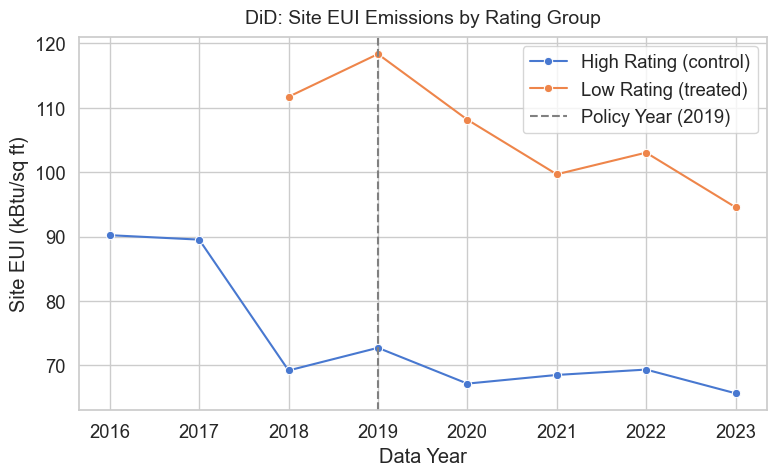

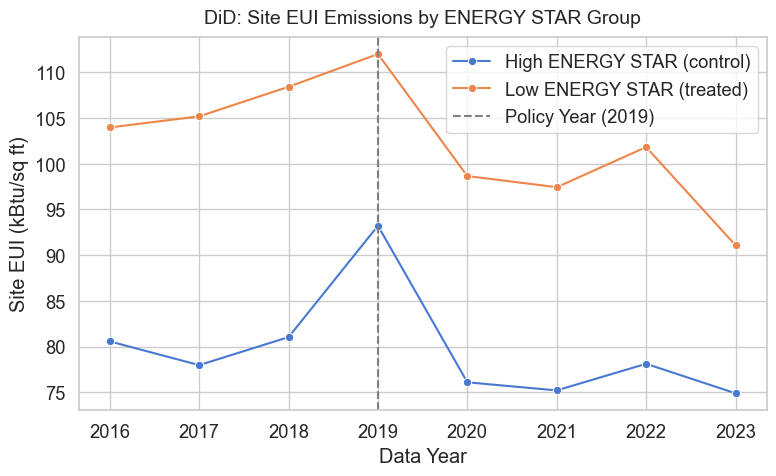

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'DiD: Site EUI Emissions by ENERGY STAR Group'}, xlabel='Data Year', ylabel='Site EUI (kBtu/sq ft)'>)

In [328]:
pu.plot_did_trend(
    did_df,
    year_col="Data Year",
    group_col="LowRating",
    outcome_col="Site EUI (kBtu/sq ft)",
    policy_year=2019,
    group_labels={1: "Low Rating (treated)", 0: "High Rating (control)"},
    title="DiD: Site EUI Emissions by Rating Group",
)
pu.plot_did_trend(
    did_df,
    year_col="Data Year",
    group_col="LowScore",
    outcome_col="Site EUI (kBtu/sq ft)",
    policy_year=2019,
    group_labels={1: "Low ENERGY STAR (treated)", 0: "High ENERGY STAR (control)"},
    title="DiD: Site EUI Emissions by ENERGY STAR Group",
)